# Interference of Trotterization (Grouping, Lattice)

In [1]:
## import necessary packages
import random
import numpy as np
from numpy.linalg import matrix_power
from scipy.linalg import expm

import matplotlib.pyplot as plt

from lattice_hamiltonians import *

import jax
from jax import numpy as jnp
print('jax.device:', jax.devices())

{2: 5.063692892044908e-13, 3: 0.0692679920883431, 4: 0.09249259661787239, 5: 0.06946199700491076, 6: 0.0692679920872576, 7: 0.06953850524965834, 8: 0.07961132594629773, 9: 0.07998561183136232}
jax.device: [CpuDevice(id=0)]


## Heisenberg model

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIIIIII', 'IXXIIIIIII', 'IIXXIIIIII', 'IIIXXIIIII', 'IIIIXXIIII', 'IIIIIXXIII', 'IIIIIIXXII', 'IIIIIIIXXI', 'IIIIIIIIXX', 'XIIIIIIIIX']
inter_yy: ['YYIIIIIIII', 'IYYIIIIIII', 'IIYYIIIIII', 'IIIYYIIIII', 'IIIIYYIIII', 'IIIIIYYIII', 'IIIIIIYYII', 'IIIIIIIYYI', 'IIIIIIIIYY', 'YIIIIIIIIY']
inter_zz: ['ZZIIIIIIII', 'IZZIIIIIII', 'IIZZIIIIII', 'IIIZZIIIII', 'IIIIZZIIII', 'IIIIIZZIII', 'IIIIIIZZII', 'IIIIIIIZZI', 'IIIIIIIIZZ', 'ZIIIIIIIIZ']
external ['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIIIIII', 'IIXXIIIIII', 'IIIIXXIIII', 'IIIIIIXXII', 'IIIIIIIIXX']
inter_xx_odd: ['IXXIIIIIII', 'IIIXXIIIII', 'IIIIIXXIII', 'IIIIIIIXXI', 'XIIIIIIIIX']
external_even ['ZIIIIIIIII', 'IIZIIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIIZI']
external_odd ['IZIIIIIIII', 'IIIZIIIIII', 'IIIIIZIIII', 'I

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


FileNotFoundError: [Errno 2] No such file or directory: './figs/tri_group_n=10_t=20_norm=spectral.pdf'

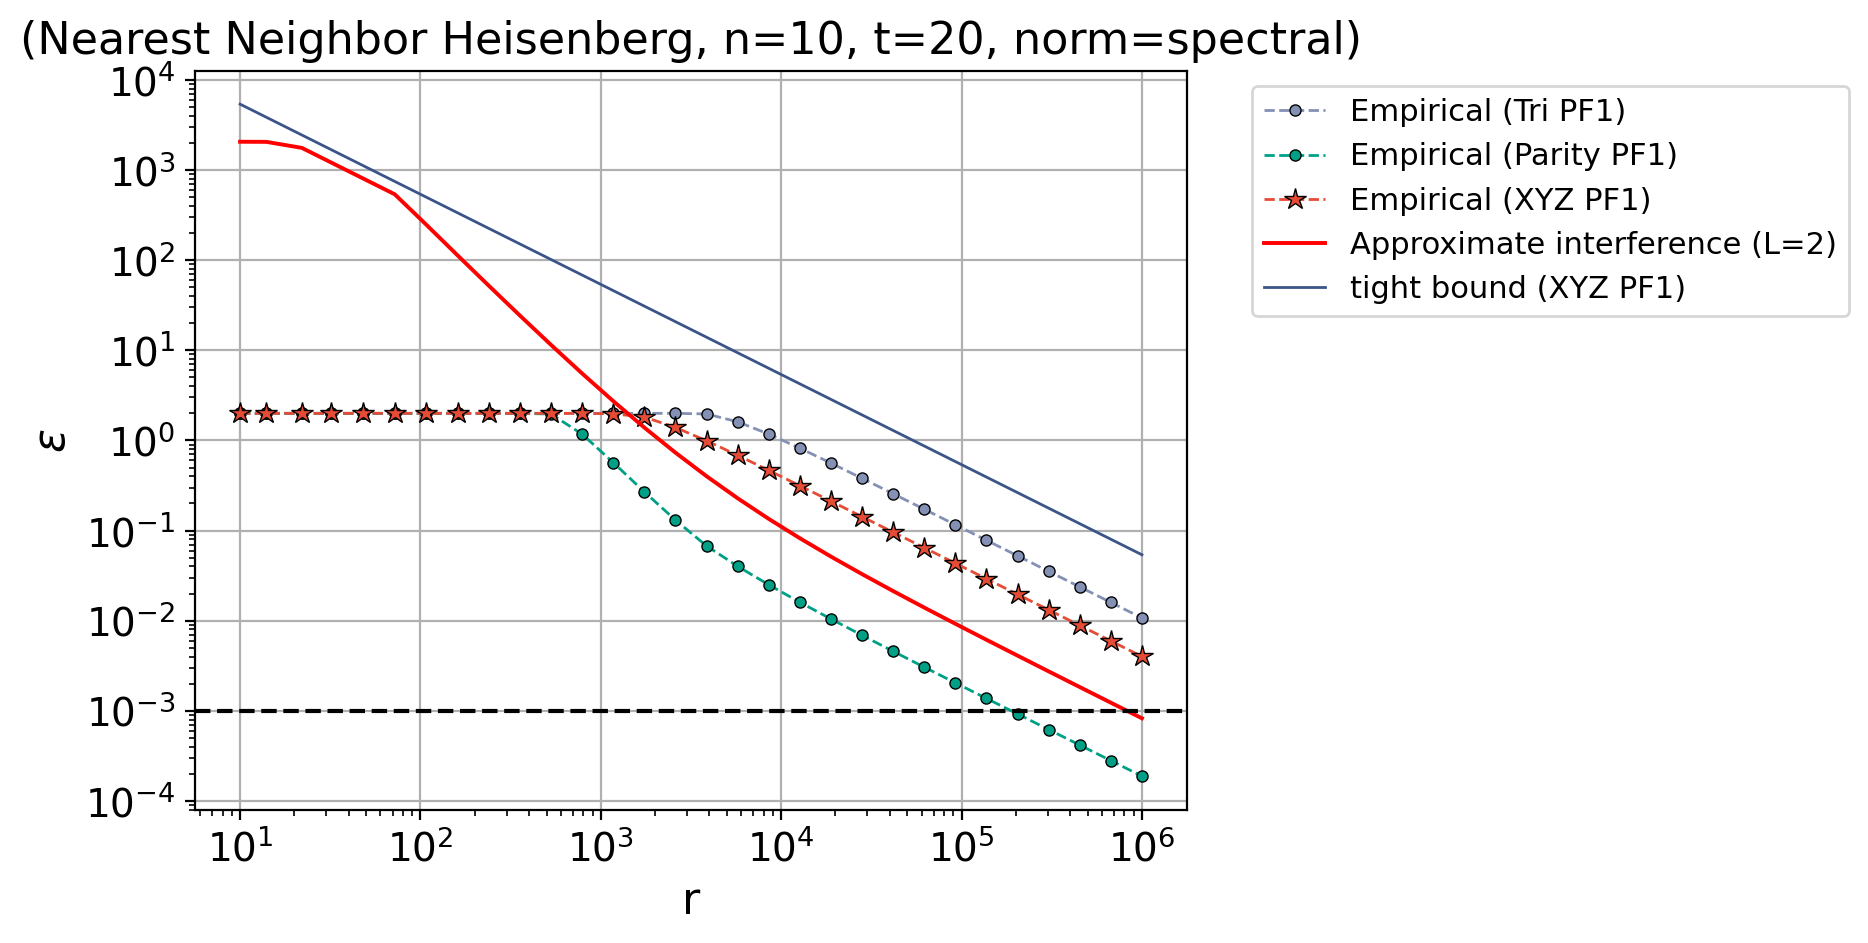

In [2]:
from scipy.sparse import csr_matrix

err_norm = 'spectral' # HS, spectral
n_qubit = 10; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
heisenberg.partition(method='tri', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

tri_group_sparse = [csr_matrix(heisenberg.term0), csr_matrix(heisenberg.term1), csr_matrix(heisenberg.term2)]
tri_group = [heisenberg.term0.to_matrix(), heisenberg.term1.to_matrix(), heisenberg.term2.to_matrix()]

r_list = np.logspace(1, 6, num=30, dtype=int)
r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

xyz_group_sparse = [csr_matrix(heisenberg.xx), csr_matrix(heisenberg.yy), csr_matrix(heisenberg.zz) + csr_matrix(heisenberg.z)]
xyz_group = [heisenberg.xx.to_matrix() , heisenberg.yy.to_matrix(), heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()]
# xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
e_pf1_tight_xyz = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
# e_pf1_tight_parity = np.array([tight_bound(parity_group, 1, t, r) for r in r_list])
# e_pf1_tight_tri = np.array([tight_bound(tri_group, 1, t, r) for r in r_list])
# e_pf2_tight = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])

# interf_bound = np.array([interference_bound(parity_group, t, r) for r in r_list])
approx_interference_bound = np.array([approx_interf_bound(xyz_group, parity_group, n_qubit, t, r) for r in r_list])
tri_bound = np.array([triangle_bound(xyz_group, 1, t, r) for r in r_list])

exact_U = expm(-1j * t * sum(xyz_group))
# exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(unitary_matrix_product(parity_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf1_tri_list = [op_error(unitary_matrix_product(tri_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
# pf2_parity_list = [op_error(matrix_power(pf(parity_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_tri_list, '.--', label= 'Empirical (Tri PF1)')
data_plot(r_list, pf1_parity_list, '.--', label= 'Empirical (Parity PF1)')
# data_plot(r_list, pf2_parity_list, '.:', label= 'Empirical (Parity PF2)')

pf1_xyz_list = [op_error(unitary_matrix_product(xyz_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
# pf2_xyz_list = [op_error(matrix_power(pf(xyz_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
# data_plot(r_list, pf2_xyz_list, '*:', label= 'Empirical (XYZ PF2)')

data_plot(r_list, approx_interference_bound, 'r-', linewidth=1.4, label=r'Approximate interference (L=2)')
# data_plot(r_list, e_pf1_tight_tri, '-', label=r'tight bound (Tri PF1)', linewidth=1)
# data_plot(r_list, e_pf1_tight_parity, '-', label=r'tight bound (Parity PF1)', linewidth=1)
data_plot(r_list, e_pf1_tight_xyz, '-', label=r'tight bound (XYZ PF1)', linewidth=1)
# data_plot(r_list, e_pf2_tight, '-', label=r'tight bound (XYZ PF2)', linewidth=1)

# data_plot(r_list, tri_bound, 'p--', label=r'triangle?loose  (XYZ PF1)', linewidth=1, alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf1, 'p--', label=r'analytic bound (XYZ PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf2, 'p:', label=r'analytic bound (XYZ PF2)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf1, '^--', label=r'analytic bound (parity PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf2, '^:', label=r'analytic bound (parity PF2)', alpha=0.6)

# data_plot(r_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
# data_plot(r_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
# data_plot(r_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, t={t}, norm={err_norm})')
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/tri_group_n={n_qubit}_t={t}_norm={err_norm}.pdf', bbox_inches='tight')

In [ ]:
n_qubit = 10; epsilon = 0.001
t = 2 * n_qubit 
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

r_list = np.logspace(1, 6, num=30, dtype=int)
r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

interf_bound = np.array([interference_bound(parity_group, t, r) for r in r_list])

xyz_group = [heisenberg.xx , heisenberg.yy, heisenberg.zz + heisenberg.z]
# xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
e_pf1_tight = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
e_pf2_tight = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])

tri_bound = np.array([triangle_bound(xyz_group, 1, t, r) for r in r_list])

# ana_bound_xyz_pf1 = np.array([analytic_bound(xyz_group, 1/2, t, r) for r in r_list_truncated])
# ana_bound_xyz_pf2 = np.array([analytic_bound(xyz_group, 2/2, t, r) for r in r_list_truncated])

# ana_bound_parity_pf1 = np.array([analytic_bound(parity_group, 1/2, t, r) for r in r_list_truncated])
# ana_bound_parity_pf2 = np.array([analytic_bound(parity_group, 2/2, t, r) for r in r_list_truncated])

exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(matrix_power(unitary_matrix_product(parity_group, t=t/r), r), exact_U) for r in r_list]
# pf2_parity_list = [op_error(matrix_power(pf(parity_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_parity_list, '.--', label= 'Empirical even/odd PF1')
# data_plot(r_list, pf2_parity_list, '.:', label= 'Empirical even/odd PF2')

pf1_xyz_list = [op_error(matrix_power(unitary_matrix_product(xyz_group, t=t/r), r), exact_U) for r in r_list]
# pf2_xyz_list = [op_error(matrix_power(pf(xyz_group, 2, t=t/r), r), exact_U) for r in r_list]
data_plot(r_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
# data_plot(r_list, pf2_xyz_list, '*:', label= 'Empirical (XYZ PF2)')

data_plot(r_list, interf_bound[:, 0], 'r-', linewidth=1.4, label=r'Interference (L=2)')
data_plot(r_list, e_pf1_tight, '-', label=r'tight bound (XYZ PF1)', linewidth=1)
data_plot(r_list, e_pf2_tight, '-', label=r'tight bound (XYZ PF2)', linewidth=1)
data_plot(r_list, tri_bound, 'p--', label=r'triangle?loose  (XYZ PF1)', linewidth=1, alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf1, 'p--', label=r'analytic bound (XYZ PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_xyz_pf2, 'p:', label=r'analytic bound (XYZ PF2)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf1, '^--', label=r'analytic bound (parity PF1)', alpha=0.6)
# data_plot(r_list_truncated, ana_bound_parity_pf2, '^:', label=r'analytic bound (parity PF2)', alpha=0.6)

data_plot(r_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
data_plot(r_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
data_plot(r_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, t={t})')
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/bound_1from2_n={n_qubit}_t={t}.pdf', bbox_inches='tight')

In [ ]:
n_qubit = 10
# t = n_qubit; epsilon = 0.001
r = 10000
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
xyz_group = [heisenberg.xx , heisenberg.yy, heisenberg.zz + heisenberg.z]

def herm2unitary(H_list, dt):
    return [expm(-1j * dt * H) for H in H_list]

def exact_U(t):
    return expm(-1j * t * sum(parity_group))

# def matrix_product(list_U, tdt=1):
#     vmapped_multi_dot = jax.vmap(jnp.linalg.multi_dot)
#     product = vmapped_multi_dot([matrix_power(U, tdt) for U in list_U])
#     return product

# dt = 0.001
# parity_group_U = herm2unitary(parity_group, dt)
# xyz_group_U = herm2unitary(xyz_group, dt)

vmapped_multi_dot = jax.vmap(jnp.linalg.multi_dot)

t_list = list(set(np.logspace(-1, 3, num=20, dtype=int)))
t_list.sort()
print('t_list: \n', t_list)

interf_bound = np.array([interference_bound(parity_group, t, r) for t in t_list])

e_xyz_pf1_tight = np.array([tight_bound(xyz_group, 1, t, r) for t in t_list])
e_par_pf1_tight = np.array([tight_bound(parity_group, 1, t, r) for t in t_list])
pf1_parity_list = [op_error(matrix_power(np.linalg.multi_dot(herm2unitary(parity_group, t/r)), r), exact_U(t)) for t in t_list]
data_plot(t_list, pf1_parity_list, '.--', label= 'Empirical (Parity PF1)')

pf1_xyz_list = [op_error(matrix_power(np.linalg.multi_dot(herm2unitary(xyz_group, t/r)), r), exact_U(t)) for t in t_list]
data_plot(t_list, pf1_xyz_list, '*--', label= 'Empirical (XYZ PF1)')
data_plot(t_list, e_xyz_pf1_tight, ':', label=r'Tight bound (XYZ PF1)', linewidth=1)
data_plot(t_list, e_par_pf1_tight, ':', label=r'Tight bound (PAR PF1)', linewidth=1)

# data_plot(t_list, interf_bound[:, 0], 'r-', linewidth=1.4, label=r'Interference bound (L=2)')
data_plot(t_list, interf_bound[:, 1], 'y--', alpha=0.7, label=r'$\min(||H_0||,||H_1||)\, t/r$')
data_plot(t_list, interf_bound[:, 2], '--', alpha=0.7, label=r'$\frac{1}{2}||[H_0,H_1]||\, t^2/r$') 
data_plot(t_list, interf_bound[:, 3], 'g--', alpha=0.7, label=r'$C_3\frac{t^3}{r^2}$', linewidth=1)
# plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
# plt.xscale("log")
plt.yscale("log")
plt.xlabel('t')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Nearest Neighbor Heisenberg, n={n_qubit}, r={r})')
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/NN_Heisenberg_n={n_qubit}_r={r}.pdf', bbox_inches='tight')

In [ ]:
n_qubit = 10
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
xyz_group = [heisenberg.xx , heisenberg.yy, heisenberg.zz]
# xyz_group = [heisenberg.xx , heisenberg.yy, heisenberg.zz + heisenberg.z]

R_parity = commutator(parity_group[0], parity_group[1])
R_xyz = commutator(xyz_group[0], xyz_group[1]) + commutator(xyz_group[1], xyz_group[2]) + commutator(xyz_group[2], xyz_group[0])
# print(R_parity)
# print(R_xyz)
# print(R_xyz - R_parity)

matrix_plot(R_xyz - R_parity)

In [ ]:
print(tight_bound(xyz_group, 1, 10, 10000))
print(tight_bound(parity_group, 1, 10, 10000))

### Power-law Heisenberg

In [ ]:
n_qubit = 5; epsilon = 0.001; time = n_qubit 
alpha = 0.01
heisenberg = ham.heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.power_law(alpha, verbose=True)
# xyz_group = [heisenberg.pow_xx, heisenberg.pow_yy, heisenberg.pow_zz + heisenberg.z]
h_x = heisenberg.pow_xx 
h_y = heisenberg.pow_yy
h_z = heisenberg.pow_zz + heisenberg.z
xyz_group = [h_x, h_y, h_z]
r_list = np.logspace(1, 7, num=50, dtype=int)
xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
xyz_markers = ['--', '--', '--', '--', '--', '--']

exact_exp_sum = expm(-1j * t * sum(xyz_group))
pow_pf1_xyz_list = [utils.operator_err(matrix_power(utils.unitary_matrix_product(xyz_group, t=t/r), r), exact_exp_sum) for r in r_list]
pow_pf2_xyz_list = [utils.operator_err(matrix_power(utils.second_order_trotter(xyz_group, t=t/r), r), exact_exp_sum) for r in r_list]
utils.data_plot(r_list, pow_pf1_xyz_list, '*--', label= 'Empirical XYZ PF1')
utils.data_plot(r_list, pow_pf2_xyz_list, '*:', label= 'Empirical XYZ PF2')
xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
C_tight = 0.5 * (np.linalg.norm(utils.commutator(h_y+h_z, h_x), ord=2) + np.linalg.norm(utils.commutator(h_z, h_y), ord=2))
e_tight = np.array([C_tight * t**2 / r for r in r_list]) 
c_pf2_1 = np.linalg.norm(utils.commutator(h_x+h_y, utils.commutator(h_y+h_z, h_x)), ord=2) + np.linalg.norm(utils.commutator(h_z, utils.commutator(h_z, h_y)), ord=2)
c_pf2_2 = np.linalg.norm(utils.commutator(h_x, utils.commutator(h_x, h_y+h_z)), ord=2) + np.linalg.norm(utils.commutator(h_y, utils.commutator(h_y, h_z)), ord=2)
e_pf2_tight = np.array([c_pf2_1 * t**3 / r**2 / 12 + c_pf2_2 *  t**3 / r**2 / 24 for r in r_list]) 
# trotter_error_list, trotter_error_list_2nd = utils.trotter_error(parity_group, r_list, t)
# for i in range(len(trotter_error_list[0])):
#     utils.data_plot(r_list, trotter_error_list[:,i], parity_markers[i], label= parity_label[i])

plt.plot(r_list, e_tight, 'g--', label=r'tight bound', linewidth=1)
plt.plot(r_list, e_pf2_tight, 'm--', label=r'tight bound', linewidth=1)
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Power-law Heisenberg, n={n_qubit}, alpha={alpha})')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### Compare even/odd grouping and XYZ grouping

In [ ]:
n_qubit = 8; epsilon = 0.001
# time = 5
time = n_qubit 
heisenberg = ham.heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
r_list = np.logspace(1, 6, num=6, dtype=int)
parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.-']

# plot_trotter_error_vs_r(epsilon, parity_group, r_list, parity_label, parity_markers, plot=True)

trotter_error_list, trotter_error_list_2nd = utils.trotter_error(parity_group, r_list, time)
for i in range(len(trotter_error_list[0])):
    utils.data_plot(r_list, trotter_error_list[:,i], '*-', label=parity_label[i] + ' (1st)')
    # utils.data_plot(r_list, trotter_error_list[:,i], parity_markers[i], label=parity_label[i] + ' (1st)')

for i in range(len(trotter_error_list_2nd[0])):
    utils.data_plot(r_list, trotter_error_list_2nd[:,i], 'o-', label=parity_label[i] + ' (2nd)')

xyz_group = [heisenberg.xx, heisenberg.yy, heisenberg.zz + heisenberg.z]
xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
trotter_error_list, trotter_error_list_2nd = utils.trotter_error(xyz_group, r_list, time)
for i in range(len(trotter_error_list[0])):
    utils.data_plot(r_list, trotter_error_list[:,i], '*:', label=xyz_label[i] + ' (1st)')
    # plt.plot(r_list, trotter_error_list[:,i], '-', markeredgecolor='black', label='order/group: ' + xyz_label[i] + ' (1st order)', alpha=0.6)

for i in range(len(trotter_error_list_2nd[0])):
    utils.data_plot(r_list, trotter_error_list_2nd[:,i], '^:', label=xyz_label[i] + ' (2nd)', alpha=0.3)

plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Nearest-neighbor Heisenberg, n={n_qubit}, t={time})')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')

In [ ]:
from qiskit.quantum_info.operators import Operator, Pauli

n_qubit = 6; epsilon = 0.001
Jx = 2.0; Jy = 2.0; Jz = 2.0; h = 0.5
# time = 5
time = n_qubit
# print('time: ', time)
heisenberg = ham.heisenberg_1d(n=n_qubit, Jx=Jx, Jy=Jy, Jz=Jz, h=h, verbose=True)
# term_list = np.array([heisenberg.inter_xx, heisenberg.inter_yy, heisenberg.inter_zz, heisenberg.external]).flatten()
# term_list = ['XXI', 'IXX', 'YYI', 'IYY', 'ZZI', 'IZZ', 'ZII', 'IZI', 'IIZ']
# term_list = ['XXI', 'IXX', 'YYI', 'IYY', 'ZZI', 'IZZ', 'ZII', 'IZI', 'IIZ']
# term_list = ['XXI', 'IXX', 'YYI', 'IYY', 'ZZI', 'IZZ']
# term_list = ['XXI', 'IXX', 'YYI', 'IYY', 'ZZI' 'IZZ', 'ZII' 'IZI' 'IIZ']
# term_list = ['XX', 'YY', 'ZZ']
# term_list = ['XX', 'YY', 'ZZ', 'IZ', 'ZI']
# L = len(term_list)
# print('L= ', term_list)
# ham_list = [Operator(Pauli(item)) for item in term_list]
ham_list = [Jx * Operator(Pauli(item)) for item in heisenberg.inter_xx] + [Jy * Operator(Pauli(item)) for item in heisenberg.inter_yy] + [Jz * Operator(Pauli(item)) for item in heisenberg.inter_zz] + [h * Operator(Pauli(item)) for item in heisenberg.external]
# print(ham_list)
r_list = np.logspace(1, 6, num=6, dtype=int)
print(r_list)

heisenberg.partition(method='parity', verbose=True)
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.-']

# plot_trotter_error_vs_r(epsilon, parity_group, r_list, parity_label, parity_markers, plot=True)

parity_trotter_error_list, parity_trotter_error_list_2nd = utils.trotter_error(parity_group, r_list, time)
for i in range(len(parity_trotter_error_list[0])):
    utils.data_plot(r_list, parity_trotter_error_list[:,i], 'o-', label=parity_label[i] + ' (1st)')
    # utils.data_plot(r_list, trotter_error_list[:,i], parity_markers[i], label=parity_label[i] + ' (1st)')

for i in range(len(parity_trotter_error_list_2nd[0])):
    utils.data_plot(r_list, parity_trotter_error_list_2nd[:,i], 'o-', label=parity_label[i] + ' (2nd)')


trotter_error_list, trotter_error_list_2nd = utils.trotter_error(ham_list, r_list, time)
# print(len(perm_list))
# print(trotter_error_list)
for i in range(len(trotter_error_list[0])):
    # if i % 10 == 0: print(i)
    utils.data_plot(r_list, trotter_error_list[:,i], '*--', label=' (1st)', alpha=0.3)

for i in range(len(trotter_error_list_2nd[0])):
    # if i % 10 == 0: print(i)
    utils.data_plot(r_list, trotter_error_list_2nd[:,i], '*:', label=' (1st)', alpha=0.3)

plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(f'Nearest-neighbor Heisenberg, n={n_qubit}, t={time}, L={L}')

## Commutation of XX, YY and ZZ ??

In [ ]:
# define Pauli matrices 
import numpy as np
from scipy.linalg import expm

sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)    

t = 1.2
print(expm(-1j * t * (sigma_x + sigma_y + sigma_z)))
print(expm(-1j * t * sigma_x) @ expm(-1j * t * sigma_y) @ expm(-1j * t * sigma_z))

In [ ]:
from qiskit.quantum_info.operators import Operator, Pauli
import numpy as np
# set np precision
np.set_printoptions(precision=6)
FLOATING_POINT_PRECISION = 1e-10

t = 1.3 
print('XX=\n', Operator(Pauli('XX')))
# U1 = expm(-1j * t * Operator(Pauli('X'))) @ expm(-1j * t * Operator(Pauli('Y'))) @ expm(-1j * t * Operator(Pauli('Z')))
# U2 = expm(-1j * t * (Operator(Pauli('X')) + Operator(Pauli('Y')) + Operator(Pauli('Z'))) )
U1 = expm(-1j * t * Operator(Pauli('XX'))) @ expm(-1j * t * Operator(Pauli('YY'))) @ expm(-1j * t * Operator(Pauli('ZZ')))
U2 = expm(-1j * t * (Operator(Pauli('XX')) + Operator(Pauli('YY')) + Operator(Pauli('ZZ'))) )
# print(U1)
# print(U2)
# print with precision
# print(f'{U1-U2}')
matrix_plot(U1-U2)

In [ ]:
from scipy import sparse
m = Operator(Pauli('IIIIIIZ')).to_matrix()
sparse_m = sparse.csr_matrix(m)
# print(sparse_m)
# m

## Power-law

In [ ]:
n_qubit = 5; epsilon = 0.001
time = n_qubit * 2
alpha = 4
heisenberg = heisenberg_1d(n=n_qubit, Jx=2.0, Jy=2.0, Jz=2.0, h=0.5, verbose=True)
heisenberg.power_law(alpha, verbose=True)
xyz_group = [heisenberg.pow_xx, heisenberg.pow_yy, heisenberg.pow_zz + heisenberg.z]
r_list = np.logspace(1, 6, num=6, dtype=int)
xyz_label = ['XYZ', 'YXZ', 'ZXY', 'ZYX', 'XZY', 'YZX'] 
xyz_markers = ['--', '--', '--', '--', '--', '--']

utils.plot_trotter_error_vs_r(epsilon, time, xyz_group, r_list, xyz_label, xyz_markers, plot=True, locate=False)

plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylabel(r'$\epsilon$')
plt.title(rf'(Power-law Heisenberg, n={n_qubit}, alpha={alpha})')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Hubbard model